In [24]:
%pylab nbagg
from tvb.simulator.lab import *

Populating the interactive namespace from numpy and matplotlib


In [25]:
epileptic = [9,47]
almost_epileptic = [2,40]
#pulses = [1, 10]
pulse_length = 100
amps = [0.7, 0.8, 0.9, 1]
SIM_LEN = 10000 #ms
FREQ = 1
amplification = 10 #up to 20

In [26]:
epileptors = models.Epileptor(Ks=-0.2, Kf=0.1, r=0.00015)
epileptors.x0 = np.ones((76))*-2.4 #set all brain regions non-epileptic
epileptors.x0[almost_epileptic] = np.ones((2))*-1.9 #overwrite as epileptogenic; borderline epileptic ('close to epilepsy threshold')
epileptors.x0[epileptic] = np.ones((3))*-1.6 #rHC and lHC are epileptic

#stuff
con = connectivity.Connectivity(load_default=True)
coupl = coupling.Difference(a=1.)
heunint = integrators.HeunDeterministic(dt=0.05)

# load the default region mapping
rm = region_mapping.RegionMapping(load_default=True)

pre_expr = "-y0+y3" #5 abstract state variables (plus one that is implicitly defined), this combination was found to correspond to EEG signals

#Initialise some Monitors with period in physical time
mon_tavg = monitors.TemporalAverage(period=1.)
mon_SEEG = monitors.iEEG(load_default=True,
                         region_mapping=rm,
                         period=1.,
                         ) #intracranial EEG (iEEG) is a particular/specific type of stereoEEG (SEEG)

#Bundle them
what_to_watch = (mon_tavg, mon_SEEG)
#set stimulus to epileptic regions
weighting = np.ones((76))*0 #numpy.zeros((76))
weighting[epileptic] = numpy.array([2.0]) #stimulate rHC and lHC
#weighting[[69, 72]] = numpy.array([2.0]) #stimulus amplification

#this is our stimulus, simple pulse whose amplitude/value can be changed each differential instant
eqn_t = equations.PulseTrain()               #square wave
eqn_t.parameters["T"] = SIM_LEN      #period of a pulse
eqn_t.parameters["onset"] = 0
eqn_t.parameters["tau"] = SIM_LEN #N #1/(2*FREQ)
eqn_t.parameters["amp"] = 0
stim = patterns.StimuliRegion(temporal = eqn_t,
                      connectivity = con, 
                      weight = weighting)
#Configure space and time
stim.configure_space()
stim.configure_time(numpy.arange(0., SIM_LEN, heunint.dt))
#plot_pattern(stim)

#Initialise a Simulator -- Model, Connectivity, Integrator, and Monitors.
sim = simulator.Simulator(model = epileptors, 
                  connectivity = con,
                  coupling = coupl, 
                  integrator = heunint, 
                  monitors = what_to_watch,
                  stimulus = stim)
sim.configure()


WARNING  File 'hemispheres' not found in ZIP.


initial_conditions,None
coupling,Difference(a=1)
stimulus,"StimuliRegion(bound=False, value=None)"
integrator,HeunDeterministic(dt=0.05)
surface,None
connectivity,"Connectivity(bound=False, value=None)"
conduction_speed,3.0
simulation_length,1000.0
model,"Epileptor(bound=False, value=None)"
monitors,"(TemporalAverage(bound=False, value=None), iEEG(bound=False, value=None))"


<IPython.core.display.Javascript object>


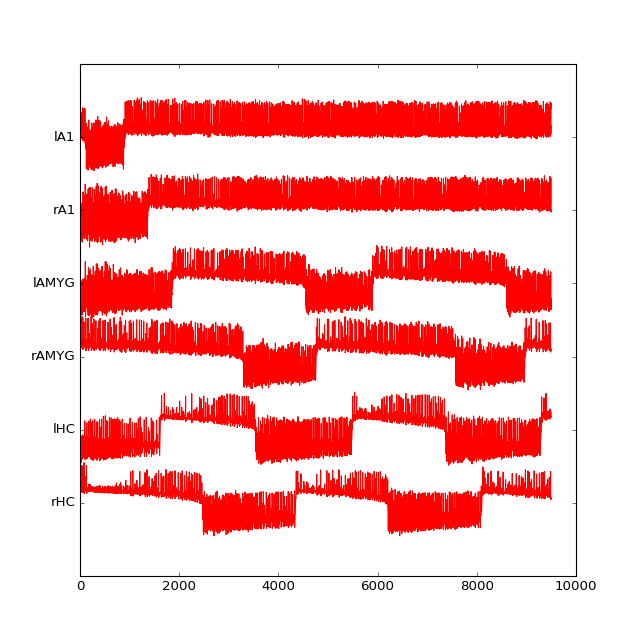

In [27]:
ttavg, tavg = [], []

for i in range(SIM_LEN / FREQ):
    (t, a), (tseeg, seeg) = sim.run(simulation_length = FREQ)
    ttavg.append(t);
    tavg.append(a[0]);
    
    
    
    
    
    
tavg /= (np.max(tavg,0) - np.min(tavg,0 ))
ioff()
#Plot raw time series
figure(figsize=(8,8))
#plot(ttavg[:], tavg[:, 0, :, 0] + np.r_[:76], 'r')
plot(ttavg[:], tavg[:, 0, [9,47,2,40,0,38], 0] + [1,2,3,4,5,6], 'r')
yticks([1,2,3,4,5,6], con.region_labels[[9,47,2,40,0,38]])
show()